In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:03<00:00, 81.3MB/s]
100% 331M/331M [00:03<00:00, 97.0MB/s]


In [3]:
import zipfile
zip= zipfile.ZipFile('/content/utkface-new.zip') #refers to the open zipfile
zip.extractall("/content") #extracts all files from UTKFace into content
zip.close()

In [4]:
import numpy as mp
import pandas as pd

In [5]:
# images have some metadata in their file names, like their age and their gender`, we will extract those and use them as y (since this is a keras multi output functional API)
import os

age=[]
gender=[]
img_path=[]

folder_path= '/content/utkface_aligned_cropped/UTKFace'
files= os.listdir(folder_path)

for file in files:
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(folder_path + '/' + file)



In [6]:
img_path[2]

'/content/utkface_aligned_cropped/UTKFace/24_1_4_20170103223935080.jpg.chip.jpg'

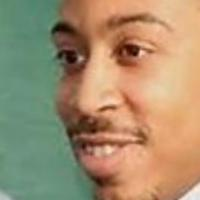

In [7]:
from keras.preprocessing import image

sample_img= image.load_img( '/content/utkface_aligned_cropped/UTKFace/33_0_1_20170113134141083.jpg.chip.jpg')
sample_img

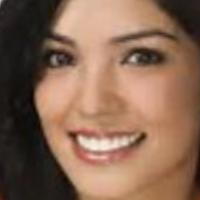

In [8]:
sample_img= image.load_img( '/content/utkface_aligned_cropped/UTKFace/24_1_4_20170103223935080.jpg.chip.jpg')
sample_img

This tells us that 0 is for males and 1 is for females

In [9]:
len(age)

23708

In [10]:
df= pd.DataFrame({'img_path': img_path,'age':age, 'gender':gender})

In [11]:
df

,img_path,age,gender
0,/content/utkface_aligned_cropped/UTKFace/33_0_...,33,0
1,/content/utkface_aligned_cropped/UTKFace/1_1_2...,1,1
2,/content/utkface_aligned_cropped/UTKFace/24_1_...,24,1
3,/content/utkface_aligned_cropped/UTKFace/16_0_...,16,0
4,/content/utkface_aligned_cropped/UTKFace/50_0_...,50,0
...,...,...,...
23703,/content/utkface_aligned_cropped/UTKFace/24_1_...,24,1
23704,/content/utkface_aligned_cropped/UTKFace/22_0_...,22,0
23705,/content/utkface_aligned_cropped/UTKFace/24_0_...,24,0
23706,/content/utkface_aligned_cropped/UTKFace/1_1_2...,1,1


#EDA

In [12]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

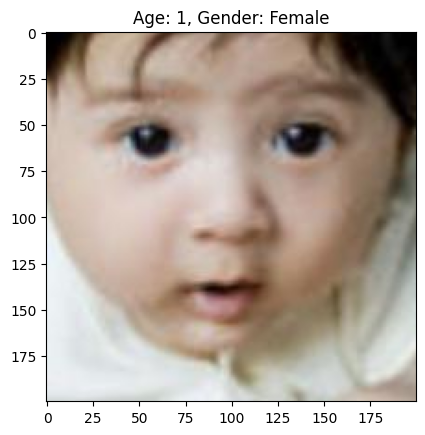

In [13]:
rand_index= random.randint(0, len(df)-1)
IMG= image.load_img(df['img_path'][rand_index])
Age=df['age'][rand_index]
Gender= df['gender'][rand_index]

#since gender is in 0 or 1 we'll use a map to dispolay it as male or female

gender_map= {
    0: 'Male',
    1: 'Female'
}


plt.title(f'Age: {Age}, Gender: {gender_map[Gender]}')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

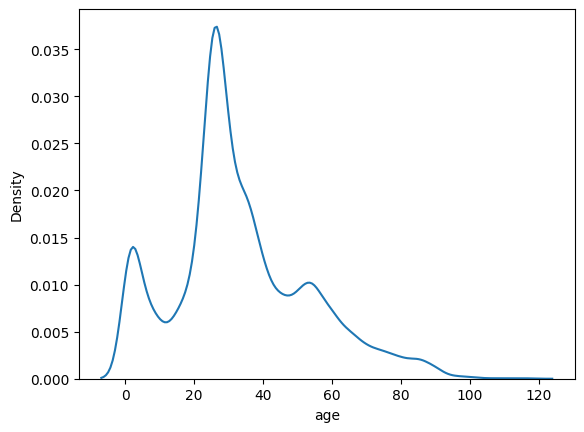

In [14]:
sns.kdeplot(df['age'])

<ipython-input-15-2e06c5a17edf>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_gp.set_xticklabels(['Male', 'Female'])


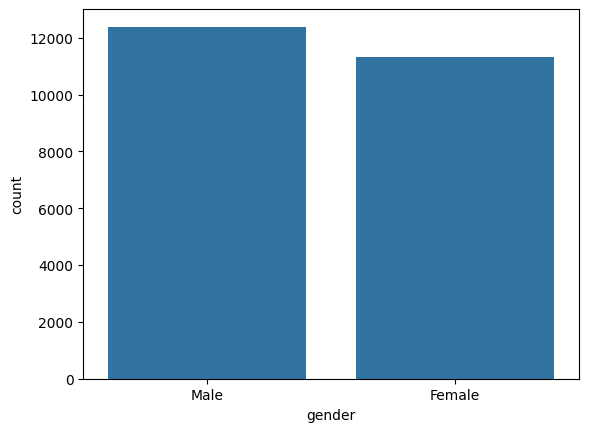

In [15]:
count_gp= sns.countplot(x='gender', data=df)

# Set custom labels for the x-axis
count_gp.set_xticklabels(['Male', 'Female'])
plt.show()

#Model Building


In [16]:
df.shape

(23708, 3)

In [32]:
#train test split
train_df= df.sample(frac=1).iloc[:20000] #frac=1 takes all the rows as sample, by setting Iloc we are limitng it
test_df= df.sample(frac=1).iloc[20000:]


# #another way of ding this is using the train_test_split from sklearn

In [33]:
# print(train_df.shape)
# print(test_df.shape)

In [34]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_datagen = ImageDataGenerator(rescale=1./255) #normalizes data and brings values between 0 and 1 from 0 to 255

validation_datagen=ImageDataGenerator(rescale=1./255)



'''does real-time augmentation, meaning it generates new, augmented versions of images on the fly
 during training. It doesn’t save or store extra images; it simply applies random transformations
  to each image every time it's used in a batch.You won't get a fixed number of new images,
   but you can observe the effect of augmentations by visualizing a few batches of augmented images. '''


"does real-time augmentation, meaning it generates new, augmented versions of images on the fly\n during training. It doesn’t save or store extra images; it simply applies random transformations\n  to each image every time it's used in a batch.You won't get a fixed number of new images,\n   but you can observe the effect of augmentations by visualizing a few batches of augmented images. "

In [35]:
# making generators


img_generator= img_datagen.flow_from_dataframe(train_df,
                                               directory=folder_path,
                                               x_col='img_path',
                                               y_col=['age','gender'],
                                               target_size=(200,200),
                                               bathc_size=64,
                                               class_mode= 'raw')

validation_generator= validation_datagen.flow_from_dataframe(test_df,
                                                   directory=folder_path,
                                                   x_col='img_path',
                                                   y_col=['age','gender'],
                                                   target_size=(200,200),
                                                   bathc_size=64,
                                                   class_mode= 'raw')



Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [36]:
# using a pretrained model of ResNet50 to build the neural network

from tensorflow.keras.applications import ResNet50
from keras.layers import *
from keras.models import Model


In [37]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3)) #3 meaning the 3 colours channels

resnet.trainable = False

# resnet_last_layer_output= resnet.layers[-1].output
# flatten= Flatten()(resnet_last_layer_output)

flatten = Flatten()(resnet.output)


dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3= Dense(512, activation='relu')(dense1)
dropout1= Dropout(0.2)(dense3)
dense4= Dense(512, activation='relu')(dense2)
dropout2= Dropout(0.2)(dense4)

output1 = Dense(1,activation='linear',name='age')(dropout1)
output2 = Dense(1,activation='sigmoid',name='gender')(dropout2)

In [38]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [39]:
model.compile(optimizer='adam',
              loss={'age': 'mae', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'})

In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 206, 206, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 100, 100, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 100, 100, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 100, 100, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 102, 102, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 50, 50, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 50, 50, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 50, 50, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 50, 50, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 50, 50, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 50, 50, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 50, 50, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 126,875,522 (483.99 MB)

 Trainable params: 103,287,810 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.848402 to fit



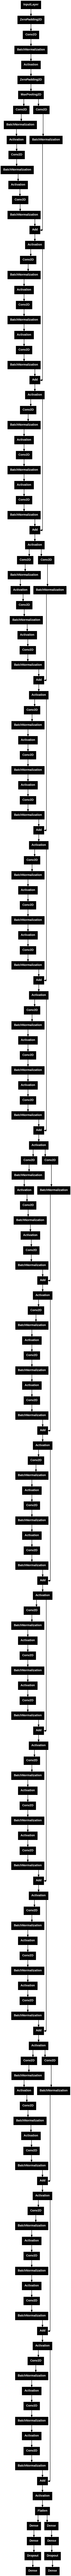

In [41]:
# # plot the model
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [43]:
model.fit(img_generator, batch_size=32, epochs=10, validation_data= validation_generator)

Epoch 1/10


OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.